In [42]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import seaborn as sns

In [43]:
SEED_NUM = 2
SEEDS = torch.arange(SEED_NUM)
EPOCHS = 10
OPTIMIZERS = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    "AdaGrad": optim.Adagrad,
    "AMSGrad": optim.Adam
}

In [44]:
# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.view(-1, 784)
        out = self.linear(x)
        return out

In [45]:
def trainval(train_loader, test_loader, model, optimizer, criterion, device, epochs=10):
    # Train the model
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0
        model.train()
        for (images, labels) in tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the training loss
            epoch_train_loss += loss.item()

        # print(f"Epoch {epoch+1} train loss: {epoch_train_loss / len(train_loader)}")
        train_loss.append(epoch_train_loss / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

        # print(f"Epoch {epoch+1} validation loss: {epoch_val_loss / len(test_loader)}")
        val_loss.append(epoch_val_loss / len(test_loader))

    return train_loss, val_loss

def test(test_loader, model, device):
    # Test the model
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            
            # Get the predicted class for each image
            _, predicted = torch.max(outputs.data, 1)
            
            # Store the true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_true, y_pred)
    # print(f"Accuracy: {accuracy}")

In [55]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())

# Create data loaders for the training and testing datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)


In [56]:
train_losses = {}
val_losses = {}
accuracy = {}
for optimizer_name in OPTIMIZERS:
    print("Running optimizer:", optimizer_name)
    train_losses[optimizer_name] = []
    val_losses[optimizer_name] = []
    for seed in SEEDS:
        torch.manual_seed(seed)

        # Instantiate the logistic regression model
        model = LogisticRegression()
        model.to(device)

        # Define the optimizer and the loss function
        if optimizer_name == "AMSGrad":
            optimizer = OPTIMIZERS[optimizer_name](model.parameters(), lr=0.01, amsgrad=True)
        else:
            optimizer = OPTIMIZERS[optimizer_name](model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        train_loss, val_loss = trainval(train_loader, test_loader, model, optimizer, criterion, device, epochs=EPOCHS)
        train_losses[optimizer_name].append(train_loss)
        val_losses[optimizer_name].append(val_loss)

        # Test the model
        acc = test(test_loader, model, device)
        accuracy[optimizer_name] = acc

Running optimizer: SGD


Running optimizer: Adam


Running optimizer: RMSprop


Running optimizer: AdaGrad


Running optimizer: AMSGrad


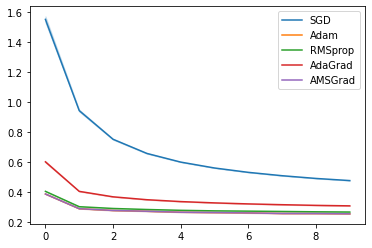

In [57]:
x = np.arange(EPOCHS)
x = np.tile(x, SEED_NUM)
for optimizer_name in OPTIMIZERS:
    y = np.concatenate(train_losses[optimizer_name])
    sns.lineplot(x=x, y=y, label=optimizer_name)

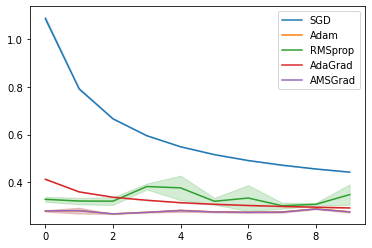

In [58]:
x = np.arange(EPOCHS)
x = np.tile(x, SEED_NUM)
for optimizer_name in OPTIMIZERS:
    y = np.concatenate(val_losses[optimizer_name])
    sns.lineplot(x=x, y=y, label=optimizer_name)